# Algo Trading- Backtrader-Master Template

In this notebook, we will build a backtrader strategy using any trading algorithm

*To do : 8889 port

In [1]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.8 MB/s 


In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
!pip install git+https://github.com/happydasch/btplotting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/happydasch/btplotting to /tmp/pip-req-build-tg5zt2_2
  Running command git clone -q https://github.com/happydasch/btplotting /tmp/pip-req-build-tg5zt2_2
  Created wheel for btplotting: filename=btplotting-0.2.1-py3-none-any.whl size=74932 sha256=5b1d3fea17c8fb7563d00ef8a12c70b673ff7d099b76e52642d0ea94c51cc683
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tu082pl/wheels/a4/8b/bc/64125606a9fb7ec0617ac7c5ca4c631dbb9dde126178932bb3
Successfully built btplotting


In [4]:
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 3.3 MB/s 
     |████████████████████████████████| 52 kB 972 kB/s 
     |████████████████████████████████| 1.6 MB 36.9 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88682 sha256=ae7c5c5a01166a7c54bc6f46b7700772f5c0b13f93cc2414049d3d462e8838cb
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=638d29ec5bc95785dd72d9be31734788d3aa595188bbf91bc7f484df5eed15d8
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [2]:
!pip install quantstats --upgrade --no-cache-dir

[1. Step 1 : Loading the algorithm](#1)

[2. Step 2 : Setting, running backtests and plots](#2)

#https://github.com/happydasch/btplotting

In [3]:
import logging
import os
import pandas as pd
from btplotting import BacktraderPlottingLive
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
import btplotting
import pyfolio as pf
import quantstats as qs

<a id='1'></a>
## 1. Step 1 : Loading the algorithm
In this step we load a sample TestStrategy which is created separately in a python file.

In [4]:
class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=15)
        self.rsi = bt.indicators.RelativeStrengthIndex()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        print('rsi:', self.rsi[0])
        if self.order:
            return

        if not self.position:
            if (self.rsi[0] < 30):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy(size=500)

        else:
            if (self.rsi[0] > 70):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(size=500)


<a id='2'></a>
## 2. Step 2 : Backtest outputs and charts
In this step, we set up a backtester, with cash amount, data and strategy name updated.

In [5]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcommission(commission=0.001)

datapath = 'FB.csv'

data = bt.feeds.PandasData(dataname=yf.download('GOOG', '2017-01-01', '2022-01-10'))

[*********************100%***********************]  1 of 1 completed


In [6]:
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
#cerebro.addanalyzer(BacktraderPlottingLive)
cerebro.addanalyzer(BacktraderPlottingLive, address="*", port=8889)
#cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="return")
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

Starting Portfolio Value: 100000.00
2017-01-24, Close, 41.19
rsi: 82.03963693140958
2017-01-25, Close, 41.78
rsi: 85.22781165138085
2017-01-26, Close, 41.61
rsi: 80.62976074270675
2017-01-27, Close, 41.17
rsi: 70.36322640040456
2017-01-30, Close, 40.12
rsi: 53.08055021773798
2017-01-31, Close, 39.84
rsi: 49.622416086624575
2017-02-01, Close, 39.78
rsi: 48.94250277902882
2017-02-02, Close, 39.93
rsi: 50.821288994200096
2017-02-03, Close, 40.07
rsi: 52.77530750278832
2017-02-06, Close, 40.07
rsi: 52.66112474702944
2017-02-07, Close, 40.35
rsi: 56.468210061503314
2017-02-08, Close, 40.42
rsi: 57.39239061414219
2017-02-09, Close, 40.48
rsi: 58.19235618285097
2017-02-10, Close, 40.68
rsi: 60.942847499111195
2017-02-13, Close, 40.96
rsi: 64.36456973378931
2017-02-14, Close, 41.02
rsi: 65.08022785944544
2017-02-15, Close, 40.95
rsi: 63.41400995130746
2017-02-16, Close, 41.21
rsi: 66.65394003550992
2017-02-17, Close, 41.40
rsi: 68.8932189237409
2017-02-21, Close, 41.58
rsi: 70.83010296340477
2


2018-01-31, Close, 58.50
rsi: 74.26336973245422
2018-02-01, Close, 58.38
rsi: 72.58173983224387
2018-02-02, Close, 55.60
rsi: 45.15323421852804
2018-02-05, Close, 52.79
rsi: 32.04275715886496
2018-02-06, Close, 54.03
rsi: 40.29568518787381
2018-02-07, Close, 52.43
rsi: 34.474346525903414
2018-02-08, Close, 50.08
rsi: 28.05861105145641
2018-02-08, BUY CREATE, 50.08
2018-02-09, BUY EXECUTED, Price: 50.86, Cost: 25431.25, Comm 25.43
2018-02-09, Close, 51.89
rsi: 37.681928034165495
2018-02-12, Close, 52.60
rsi: 41.00095853810571
2018-02-13, Close, 52.60
rsi: 41.03916797705551
2018-02-14, Close, 53.49
rsi: 45.24056782264704
2018-02-15, Close, 54.48
rsi: 49.596367344341964
2018-02-16, Close, 54.74
rsi: 50.72093545072832
2018-02-20, Close, 55.12
rsi: 52.38084558826141
2018-02-21, Close, 55.57
rsi: 54.30253843785374
2018-02-22, Close, 55.33
rsi: 53.07899885783163
2018-02-23, Close, 56.34
rsi: 57.493730577215686
2018-02-26, Close, 57.19
rsi: 60.832475249265066
2018-02-27, Close, 55.91
rsi: 53.

rsi: 52.57899087093682
2019-01-23, Close, 53.78
rsi: 53.732033156123705
2019-01-24, Close, 53.69
rsi: 53.27074229207243
2019-01-25, Close, 54.55
rsi: 57.30980313232535
2019-01-28, Close, 53.50
rsi: 51.450124303398766
2019-01-29, Close, 53.03
rsi: 49.008696855263274
2019-01-30, Close, 54.45
rsi: 55.79927954244716
2019-01-31, Close, 55.82
rsi: 61.14963896285115
2019-02-01, Close, 55.54
rsi: 59.552095545937995
2019-02-04, Close, 56.64
rsi: 63.57310495451909
2019-02-05, Close, 57.30
rsi: 65.76552298708188
2019-02-06, Close, 55.76
rsi: 57.12995818758144
2019-02-07, Close, 54.94
rsi: 53.097450931762395
2019-02-08, Close, 54.75
rsi: 52.22039888847134
2019-02-11, Close, 54.75
rsi: 52.20768428620658
2019-02-12, Close, 56.07
rsi: 58.01476849256499
2019-02-13, Close, 56.01
rsi: 57.668374753161146
2019-02-14, Close, 56.08
rsi: 58.00534893714143
2019-02-15, Close, 55.68
rsi: 55.47929302513278
2019-02-19, Close, 55.93
rsi: 56.721912340492196
2019-02-20, Close, 55.69
rsi: 55.11584641638778
2019-02-21

2020-02-19, Close, 76.33
rsi: 68.06631962432306
2020-02-20, Close, 75.91
rsi: 64.59181155403056
2020-02-21, Close, 74.26
rsi: 53.263703273803706
2020-02-24, Close, 71.08
rsi: 39.07520202728535
2020-02-25, Close, 69.42
rsi: 33.98822886702753
2020-02-26, Close, 69.66
rsi: 35.28320494665127
2020-02-27, Close, 65.90
rsi: 26.421609067476766
2020-02-27, BUY CREATE, 65.90
2020-02-28, BUY EXECUTED, Price: 63.88, Cost: 31937.50, Comm 31.94
2020-02-28, Close, 66.97
rsi: 31.65079128281593
2020-03-02, Close, 69.46
rsi: 42.04640441744993
2020-03-03, Close, 67.07
rsi: 36.340358881501686
2020-03-04, Close, 69.33
rsi: 44.07064300714975
2020-03-05, Close, 65.95
rsi: 36.8626722027171
2020-03-06, Close, 64.92
rsi: 34.97909800713572
2020-03-09, Close, 60.78
rsi: 28.648136058846276
2020-03-10, Close, 64.02
rsi: 38.09060889836252
2020-03-11, Close, 60.77
rsi: 33.32960136561462
2020-03-12, Close, 55.75
rsi: 27.586476228441782
2020-03-13, Close, 60.99
rsi: 39.32901367594987
2020-03-16, Close, 54.22
rsi: 32.09

rsi: 71.85491037422571
2021-04-19, Close, 115.12
rsi: 72.2803975403689
2021-04-20, Close, 114.68
rsi: 70.12263532889162
2021-04-21, Close, 114.66
rsi: 70.03531489035032
2021-04-22, Close, 113.40
rsi: 63.66672838954007
2021-04-23, Close, 115.76
rsi: 69.28428269539113
2021-04-26, Close, 116.34
rsi: 70.47141938061172
2021-04-27, Close, 115.36
rsi: 65.77610365179743
2021-04-28, Close, 119.00
rsi: 72.97121271961105
2021-04-29, Close, 121.49
rsi: 76.60776223852088
2021-04-30, Close, 120.51
rsi: 72.45508732330208
2021-05-03, Close, 119.76
rsi: 69.39185224353636
2021-05-04, Close, 117.71
rsi: 61.70242952876171
2021-05-05, Close, 117.84
rsi: 61.97851963261035
2021-05-06, Close, 119.07
rsi: 64.6881446494915
2021-05-07, Close, 119.93
rsi: 66.49970744740017
2021-05-10, Close, 117.08
rsi: 56.27431355627967
2021-05-11, Close, 115.44
rsi: 51.36723922219476
2021-05-12, Close, 111.95
rsi: 42.84570680297121
2021-05-13, Close, 113.10
rsi: 46.014067039779825
2021-05-14, Close, 115.81
rsi: 52.6992159435916

ValueError: 'pyfolio' is not in list

In [7]:
plot = btplotting.BacktraderPlotting()
cerebro.plot(plot, iplot=True)

[{0: <btplotting.figure.FigurePage at 0x2a877184d90>}]

                           Strategy
-------------------------  ----------
Start Period               2017-01-03
End Period                 2022-01-07
Risk-Free Rate             0.0%
Time in Market             29.0%

Cumulative Return          20.84%
CAGR﹪                     3.85%

Sharpe                     0.74
Prob. Sharpe Ratio         95.14%
Smart Sharpe               0.57
Sortino                    1.09
Smart Sortino              0.85
Sortino/√2                 0.77
Smart Sortino/√2           0.6
Omega                      1.29

Max Drawdown               -7.27%
Longest DD Days            498
Volatility (ann.)          5.26%
Calmar                     0.53
Skew                       0.11
Kurtosis                   22.07

Expected Daily %           0.01%
Expected Monthly %         0.31%
Expected Yearly %          3.21%
Kelly Criterion            12.77%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.53%
Expected Shortfall (cVaR)  -0.53%

Max Consecutive Wins       8


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-03,2020-03-23,2020-05-11,69,-7.274370,-6.930878
2,2018-03-13,2018-03-28,2018-06-18,97,-3.857477,-3.844453
3,2018-10-17,2018-12-24,2019-02-04,110,-3.465077,-3.385772
4,2020-06-11,2020-06-26,2020-07-06,25,-2.279748,-1.525142
5,2020-07-23,2020-08-04,2020-08-20,28,-2.179331,-1.997440


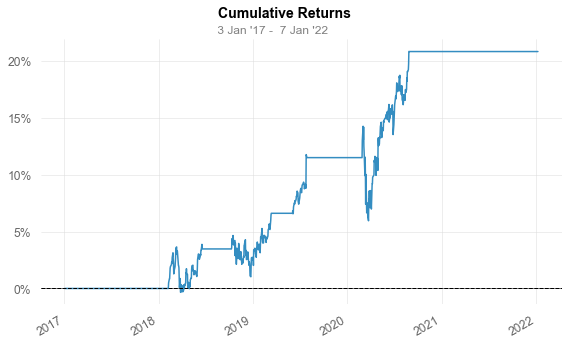

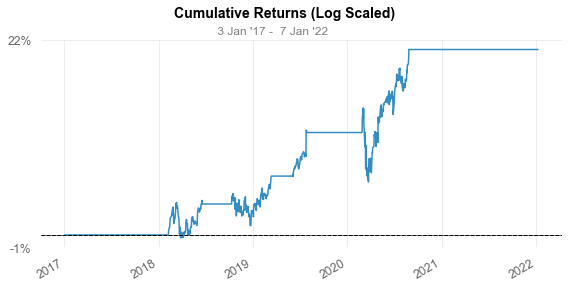

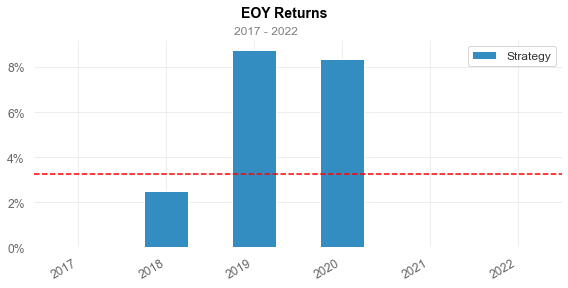

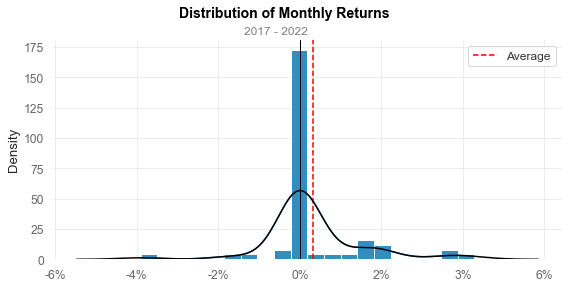

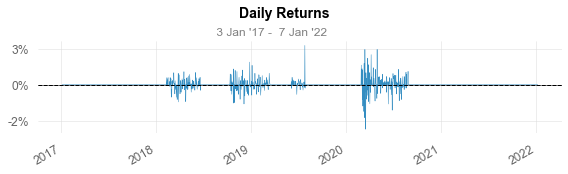

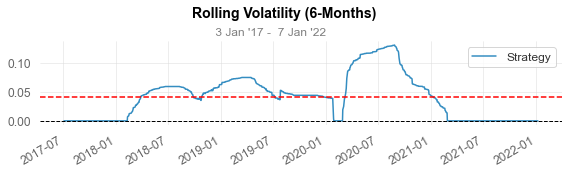

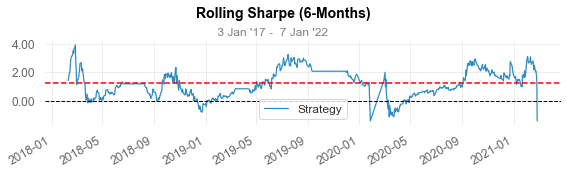

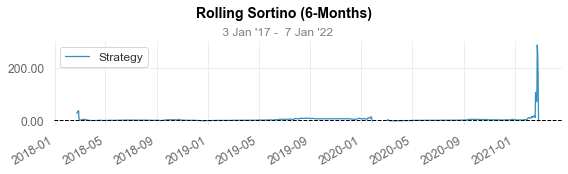

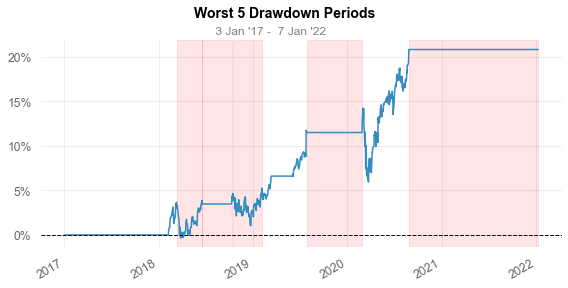

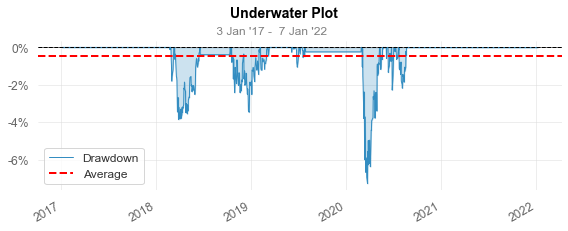

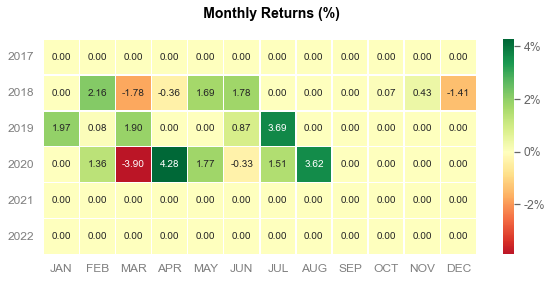

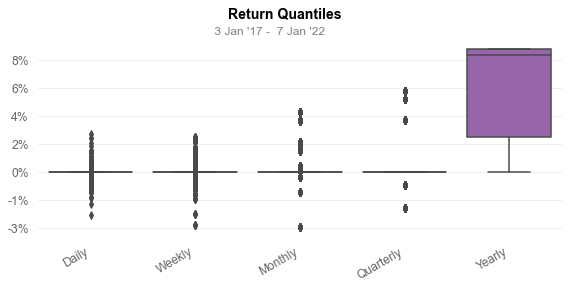

In [12]:
strat_return = strat.analyzers.getbyname("return").get_analysis()
strat_return = list(strat_return.items())
idx, values = zip(*strat_return)
strat_return = pd.Series(values, idx)

qs.reports.full(strat_return)

In [ ]:
pf.create_full_tear_sheet(returns, positions, transactions, gross_lev)